In [83]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os

import tensorflow_ranking as tfr
import tensorflow as tf
from tensorflow_serving.apis import input_pb2
import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters

PATH = os.getcwd() 

### FIXED VARIABLES FOR THE DATA PIPELINE CREATION

In [277]:
# Store the paths to files containing training and test instances.
_TRAIN_DATA_PATH = "./Dataset-tfrecords/70v30Split/train.tfrecord"
_VALID_DATA_PATH = "./Dataset-tfrecords/70v30Split/test.tfrecord"


_NAME_FEATURES = ['big_RCV', 'big_RVT', 'big_positivePartscr', 'big_negativePartscr',
                  'big_splogscr', 'big_linscr', 'big_lag1_log_ret', 'big_lag4_log_ret',
                  'big_lag1_month_log_ret'] #Name of the doc features ("doc id" and "rel" are not features)
_NUM_FEATURES = len(_NAME_FEATURES)
_LABEL_FEATURE_NAME = "rel" # The document relevance label in the tf-records.
_SIZE_FEATURE_NAME= "example_list_size" #The name of the feature that WILL BE CREATED when creating the dataset via tfr.data.build_ranking_dataset with the size of the list of examples (docs) per query

# Parameters to the scoring function.
_BATCH_SIZE = 64

### CREATING INPUT PIPELINE

In [278]:
def create_feature_columns():
    '''
    This function specifies Features via Feature Columns: (see https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html)

    Feature Columns are TensorFlow abstractions that are used to capture rich information about each feature.
    It allows for easy transformations for a diverse range of raw features and for interfacing with Estimators.
    Specifying the feature columns (and optionally, their transformaitons) is necessary to provide the parsing specifications
    to parse TFRecords.

    Consistent with our input formats for ranking, such as ELWC format, we create feature columns for context features 
    and example features.
    '''
    # We dont have context features in in our datasets (query id is not a feature)
    context_feature_columns = {}
    
    #Specifying the features that we will take from our ELWC, and their transformations (in our case all are numeric, so no transformations)
    feature_names = _NAME_FEATURES
    example_feature_columns = {
        name:
        tf.feature_column.numeric_column(name, shape=(1,), default_value=0.0)
        for name in feature_names}
    
    return context_feature_columns, example_feature_columns


def create_dataset_from_tfrecords(input_path:str,
                                  batch_sz:int,
                                  list_sz:int,
                                  shuffle:bool = False,
                                  num_epochs:int = None,
                                  data_format:str = "ELWC",
                                  compression_type:str = ''):
    '''
    Function to read ELWC tfrecords and convert them into a Ranking Dataset (dictionary of tensors) according to the parsing specs described in the next lines
    '''
    
    #Specify the TensorFlow abstractions of each feature inside context and example  dictionaries
    context_feature_columns, example_feature_columns = create_feature_columns()
    label_column = tf.feature_column.numeric_column(_LABEL_FEATURE_NAME, dtype=tf.float32, default_value=-5) #When list_sz != None, the pipeline will padd with -5 or truncate the list of examples to get to list_sz 

    #Create parsing spec dictionary from input feature_columns. The returned dictionary can be used as arg in
    #tfr.dataset.build_ranking_dataset and specifies how it should parse the document in "file_pattern" argument    
    context_feature_spec = tf.feature_column.make_parse_example_spec(context_feature_columns.values())
    example_feature_spec = tf.feature_column.make_parse_example_spec(list(example_feature_columns.values()) + [label_column])
    
    #Define the "reader_args" that we'll pass to tfr.dataset.build_ranking_dataset to specify the compression type
    _reader_arg_list = []
    if compression_type:
        assert compression_type in ["", "GZIP","ZLIB"]
        _reader_arg_list = [compression_type]

    #Build Ranking Dataset
    dataset = tfr.data.build_ranking_dataset(
        file_pattern=input_path,
        data_format=tfr.data.ELWC,
        batch_size=batch_sz, #Rate at which we read our data into our model from file
        list_size=list_sz, #Amount of docs we will take for each query - in our case we take all companies
        context_feature_spec=context_feature_spec,
        example_feature_spec=example_feature_spec,
        size_feature_name=_SIZE_FEATURE_NAME,
        reader=tf.data.TFRecordDataset,
        reader_args= _reader_arg_list,
        shuffle=shuffle, #Whether to shuffle the examples before taking them
        num_epochs=num_epochs,
        )
    
    #Define additional transformations we might want to apply to our features
    def _log1p_transform(features):
        '''
        computes elementwise log_e(|x|)*sign(x)
        '''
        transformed_feats = {
            f:tf.math.multiply(
                tf.math.log1p(
                    tf.math.abs(features[f])
                    ),
                tf.math.sign(features[f])
                )
            for f in features}
        return transformed_feats

    def _split_label_and_transform_features(features):
        label = tf.squeeze(features.pop(_LABEL_FEATURE_NAME), axis=2)
        label = tf.cast(label, tf.float32)
        features = features #_log1p_transform(features)

        return features, label

    dataset = dataset.map(_split_label_and_transform_features)
    return dataset

In [270]:
train_dataset = create_dataset_from_tfrecords(_TRAIN_DATA_PATH,
                                              batch_sz=_BATCH_SIZE,
                                              list_sz=None,
                                              shuffle=False,
                                              compression_type="")

vali_dataset = create_dataset_from_tfrecords(_VALID_DATA_PATH,
                                             batch_sz=_BATCH_SIZE,
                                             list_sz=None,
                                             shuffle=False,
                                             num_epochs=1, 
                                             compression_type="")

### DEFINING LOSS FUNCTION AND EVALUATION METRICS

In [271]:
#This loss and the evaluation functions will be passed to Keras when we build our Model

#Loss:
#Different Losses knowing that the softmax loss is representative of the ListNet apporach
_loss_obj = tfr.keras.losses.get(tfr.losses.RankingLossKey.SOFTMAX_LOSS)


In [272]:
# tf.feature_columns specifications can be passed to the "feature_columns" argument of our DNN Estimator, when we instanciate it 
context_feature_columns, example_feature_columns = create_feature_columns()

#Defining the model builder function with all possible hyperparameters that we will pass to Keras Tuner in order to tune the model
def model_builder(hp):
    
    #Define number of layers and units:
    hp_architecture = []
    num_layers = hp.Int('num_layers', 1, 2)
    for i in range(num_layers):
        if i == 0:
            units_1 = hp.Choice("l1_units", values=[5,10,15])
            hp_architecture.append(units_1)
        if i == 1:
            units_2 = hp.Choice("l2_units", values=[5,10])
            hp_architecture.append(units_2)
    
    #Drop out hyperparameter:
    hp_dropout = hp.Choice('dropout_rate', values=[0.0, 0.05, 0.1])
    
    # Using a pre-made (Canned) Keras estimator - DNNRankingNetwork - (See to know about Estimators: https://developers.googleblog.com/2017/09/introducing-tensorflow-datasets.html)
    ranking_network = tfr.keras.canned.DNNRankingNetwork( context_feature_columns=context_feature_columns,
                                                          example_feature_columns=example_feature_columns,
                                                          hidden_layer_dims = hp_architecture,
                                                          activation=tf.nn.relu,
                                                          dropout = hp_dropout
                                                          )
    
    #Define Optimization hyperparameters:
    hp_lr = hp.Choice('learning_rate', values=[5e-1,5e-2,1e-2])
    
    # Build ranker as a Functional Keras model.
    model = tfr.keras.model.create_keras_model(network=ranking_network,
                                               loss=_loss_obj,
                                               metrics=[tfr.keras.metrics.NDCGMetric(name='NDCG27',topn=27), tfr.keras.metrics.NDCGMetric(name='NDCG')],
                                               optimizer=tf.keras.optimizers.Adagrad(learning_rate=hp_lr),
                                               size_feature_name=_SIZE_FEATURE_NAME,)
    
    return model

In [273]:
LOG_DIR = f"./LOG_MODELS"

#Instantiate the tuner to perform the hypertuning
tuner = kt.Hyperband(model_builder,
                     objective= kt.Objective('val_NDCG27',direction='max'),
                     max_epochs=150,
                     factor=3,
                     hyperband_iterations=5, #Hyperband results will depend on the weights initialization, so we will run it 5 the search from different initialization
                     directory=LOG_DIR,
                     project_name=f"run_{dt.datetime.now().strftime('%m-%d-%Y_%H-%M-%S')}")

#Create callbacks to stop training early after reaching a certain value for the validation loss or validation metric.
stop_early_metric = tf.keras.callbacks.EarlyStopping(monitor='val_NDCG27', patience=15)
tensorboard = keras.callbacks.TensorBoard("./tmp/tb_logs")

In [275]:
#Run the hyperparameter search. The arguments for the search method are the same as those used for tf.keras.model.fit
tuner.search(train_dataset,
             validation_data=vali_dataset,
             steps_per_epoch=100,
             epochs=50,
             validation_steps=1,
             callbacks=[stop_early_metric, tensorboard])


Trial 148 Complete [00h 00m 39s]
val_NDCG27: 0.6005346179008484

Best val_NDCG27 So Far: 0.6190404891967773
Total elapsed time: 00h 20m 14s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [276]:
%load_ext tensorboard
%tensorboard --logdir=./tmp/tb_logs --port 25952

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 25952 (pid 21972), started 1:12:02 ago. (Use '!kill 21972' to kill it.)

In [258]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'num_layers': 1,
 'l1_units': 10,
 'dropout_rate': 0.05,
 'learning_rate': 0.05,
 'l2_units': 5,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 4,
 'tuner/round': 3,
 'tuner/trial_id': '0140'}

In [259]:
# Train the model
#Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset,
                    validation_data=vali_dataset,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_steps=1)

Epoch 1/100
100/100 [==============================] - 3s 14ms/step - loss: 4.3107 - NDCG27: 0.5976 - NDCG: 0.7295 - val_loss: 4.8173 - val_NDCG27: 0.5076 - val_NDCG: 0.6597
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 4.2683 - NDCG27: 0.6244 - NDCG: 0.7477 - val_loss: 4.7780 - val_NDCG27: 0.5066 - val_NDCG: 0.6589
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - loss: 4.2558 - NDCG27: 0.6354 - NDCG: 0.7551 - val_loss: 4.7692 - val_NDCG27: 0.5209 - val_NDCG: 0.6663
Epoch 4/100
100/100 [==============================] - 1s 13ms/step - loss: 4.2478 - NDCG27: 0.6383 - NDCG: 0.7569 - val_loss: 4.7655 - val_NDCG27: 0.5529 - val_NDCG: 0.6926
Epoch 5/100
100/100 [==============================] - 1s 14ms/step - loss: 4.2618 - NDCG27: 0.6424 - NDCG: 0.7604 - val_loss: 4.7642 - val_NDCG27: 0.5697 - val_NDCG: 0.7055
Epoch 6/100
100/100 [==============================] - 1s 13ms/step - loss: 4.2559 - NDCG27: 0.6447 - NDCG: 0.7614 - val_loss: 4.76

In [260]:
val_NDCG_per_epoch = history.history['val_NDCG27']
best_epoch = val_NDCG_per_epoch.index(max(val_NDCG_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 49


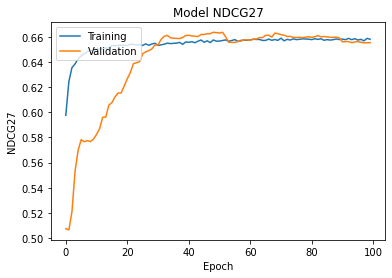

In [261]:
plt.plot(history.history['NDCG27'])
plt.plot(history.history['val_NDCG27'])
plt.title('Model NDCG27')
plt.ylabel('NDCG27')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='upper left')

In [262]:
#Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hyperhistory = hypermodel.fit(train_dataset,
               validation_data=vali_dataset,
               steps_per_epoch=100,
               epochs=best_epoch,
               validation_steps=1)

Epoch 1/49
100/100 [==============================] - 2s 12ms/step - loss: 4.2971 - NDCG27: 0.6005 - NDCG: 0.7293 - val_loss: 4.7862 - val_NDCG27: 0.5588 - val_NDCG: 0.6963
Epoch 2/49
100/100 [==============================] - 1s 7ms/step - loss: 4.2683 - NDCG27: 0.6296 - NDCG: 0.7496 - val_loss: 4.7701 - val_NDCG27: 0.5660 - val_NDCG: 0.7074
Epoch 3/49
100/100 [==============================] - 1s 10ms/step - loss: 4.2567 - NDCG27: 0.6353 - NDCG: 0.7534 - val_loss: 4.7671 - val_NDCG27: 0.5736 - val_NDCG: 0.7131
Epoch 4/49
100/100 [==============================] - 1s 12ms/step - loss: 4.2486 - NDCG27: 0.6381 - NDCG: 0.7551 - val_loss: 4.7664 - val_NDCG27: 0.5423 - val_NDCG: 0.6840
Epoch 5/49
100/100 [==============================] - 1s 13ms/step - loss: 4.2626 - NDCG27: 0.6401 - NDCG: 0.7562 - val_loss: 4.7663 - val_NDCG27: 0.5380 - val_NDCG: 0.6812
Epoch 6/49
100/100 [==============================] - 1s 14ms/step - loss: 4.2570 - NDCG27: 0.6417 - NDCG: 0.7574 - val_loss: 4.7656 - v

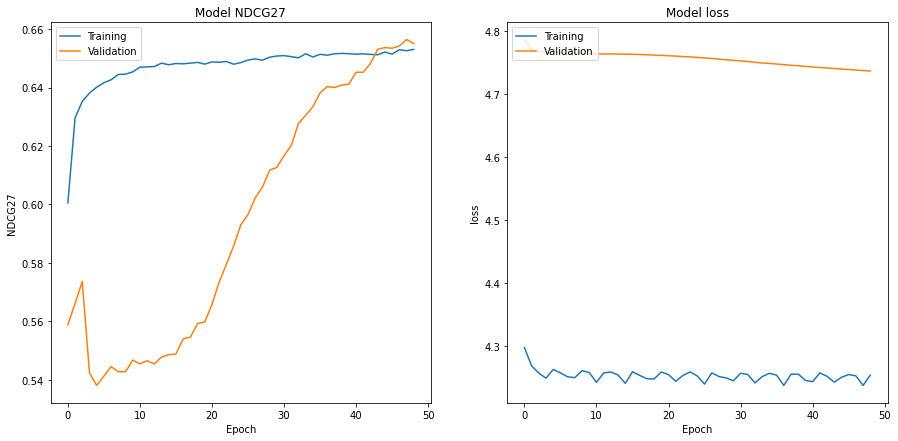

In [263]:
## Evaluate model performance
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(hyperhistory.history['NDCG27'])
ax1.plot(hyperhistory.history['val_NDCG27'])
ax1.set_title('Model NDCG27')
ax1.set_ylabel('NDCG27')
ax1.set_xlabel('Epoch')
ax1.legend(['Training','Validation'],loc='upper left')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(hyperhistory.history['loss'])
ax2.plot(hyperhistory.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Training','Validation'],loc='upper left')

### PREDICTIONS AND RANKING CREATION

In [264]:
# The maximum number of documents per query in the dataset.
# Document lists are padded or truncated to this size. That is because model.predicts accept tensors to predict in bulk
_LIST_SIZE = 108 #For each query we will be taking the max number of docs/companies - 108

test_dataset = create_dataset_from_tfrecords(_VALID_DATA_PATH,
                                             batch_sz=_BATCH_SIZE,
                                             list_sz=_LIST_SIZE,
                                             shuffle=False,
                                             num_epochs=1, 
                                             compression_type="")

predictions = hypermodel.predict(test_dataset,
                                 batch_size=None,
                                 verbose='auto',
                                 steps=None,
                                 callbacks=None)

In [265]:
#Let's parse the TFRecords in order to obtain the id of each query (DATE) + the list of ids (TICKERS) of the documents (STOCKS) in each query
raw_dataset = tf.data.TFRecordDataset([_VALID_DATA_PATH])

query_docs_list = [] #A list that will be populated with tuples (query_id, list_of_docs)
for raw_record in raw_dataset.take(-1): #take(-1) takes all the records in raw_dataset
    ELWC = input_pb2.ExampleListWithContext()
    v = ELWC.FromString(raw_record.numpy()) #v is composed by v.context and a set of examples in v.examples
    
    query_id = v.context.features.feature['qid'].bytes_list.value[0].decode('UTF-8')
    docs_list = []
    for e in v.examples:
        doc_id = e.features.feature['doc'].bytes_list.value[0].decode('UTF-8')
        docs_list.append(doc_id)
        
    query_docs_list.append((query_id, docs_list))

In [266]:
predictions_record = [] #List that will contain  the prediction tuples (date, ranking_of_companies)
queries = []
docs_per_query = []
for idx, query_docs in enumerate(query_docs_list):
    query, docs = query_docs
    scores = list(predictions[idx])
    dict_doc_scr = dict(zip(docs, scores))
    sorted_dict = dict(sorted(dict_doc_scr.items(), key=lambda item: item[1], reverse=True))
    queries.append(query)
    docs_per_query.append(list(sorted_dict.keys()))

In [267]:
result_dict = {'date': queries, 'ranking': docs_per_query}

df = pd.DataFrame.from_dict(result_dict, orient='index')
df = df.transpose()
df.to_csv('ranking_results7.csv', index=False, header=True,  encoding='utf-8')